<a href="https://colab.research.google.com/github/jpdosher/projetos_EDA/blob/main/cub_brasil_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='DarkBlue'>**Índice CUB Brasil** 

O objetivo deste notebook é a princípio fazer uma boa análise dos dados e testar/aprender um pouco.

O Custo Unitário Básico de Construção (CUB) é um indicador de custos no setor da construção calculado e divulgado pelos Sinduscons estatuais e regido pela Lei Federal 4.591/64.
O CUB Brasil é uma média ponderada dos indicadores de alguns dos principais estados da federação. Este tópico contém informações sobre a evolução do CUB Brasil e dos estados que o compõem.

**Fontes:**
> CBIC-Câmara Brasileira da Indústria da Construção - "http://www.cbicdados.com.br/menu/custo-da-construcao/cub-medio-brasil-custo-unitario-basico-de-construcao-por-m2"
>
>SINAPI: https://www.caixa.gov.br/poder-publico/modernizacao-gestao/sinapi/Paginas/default.aspx
>
>Câmara brasileira da industria da Construção: http://www.cub.org.br/cub-m2-brasil



#<font color='DarkBlue'>Importando dados, pré-visualização, pré-análise e primeiras transformações

### Montando drive
"drive.mount('/content/drive/Mydrive')"



 Após a montagem é necessário autenticação para vinvular a conta do Drive com o Colab.

>O Colab disponibilizou uma função de mount direto no menu de arquivos do notebook. Então, pare este notebook deixarei apenas como notação "carregando pacote" e "montando drive" via código.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor



In [ ]:
  #leitura do arquivo do Google Drive
df = pd.read_csv('/content/drive/MyDrive/Data Science/Dataset/df_cub_index.csv') #parse_dates=['year','month']


---

## Pré-visualizando os dados carregados

Visão geral da tabela:

In [ ]:
df.shape

(3548, 9)

In [ ]:
#primeiras linhas
df.head()

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
0,2007,2,AL,611.28,325.22,242.30,26.49,17.27,2.630
1,2007,3,AL,606.19,334.63,242.30,22.75,6.51,2.625
2,2007,4,AL,613.36,341.80,242.30,22.75,6.51,2.630
3,2007,5,AL,619.35,336.79,254.65,21.40,6.51,2.635
4,2007,6,AL,617.76,334.43,254.65,22.28,6.40,2.660


In [ ]:
#últimas linhas
df.tail()

,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
3543,2021,3,SC,2171.33,819.38,1300.81,47.63,3.52,6.35
3544,2021,4,SC,2203.29,848.55,1303.66,47.50,3.58,6.78
3545,2021,5,SC,2253.79,879.74,1322.23,48.22,3.61,6.86
3546,2021,6,SC,2307.92,896.13,1358.30,49.74,3.75,6.87
3547,2021,7,SC,2329.85,909.25,1366.99,49.84,3.78,7.12


---
Descrição das colunas, segundo o  do provedor do DataSet:




* state: unidade federativa do brasil

* globalvalue: valor total 

* cmvalue: valor componentes materiais

* cmovalue: valor componentes mão de obra 

* cdavalue: valor componentes despesa administrativa

* ce_value: valor componentes equipamento

* (globalvalue = cmvalue + cmovalue + cdavalue + ce_value )

> **Todas as colunas de valor utilizam a unidade R$/m²

* ca50_value: evolução do valor do aço ca50 10mm no período (R$/Kg)

---

In [ ]:
#Quantidade de registros por ano
dados_por_ano = df.groupby('year').year.count()
dados_por_ano

year
2007    220
2008    240
2009    240
2010    240
2011    240
2012    240
2013    240
2014    240
2015    241
2016    252
2017    252
2018    252
2019    252
2020    259
2021    140
Name: year, dtype: int64

### Visualização com o data_table do Colab

Recentemente descobri um recurso do Colab para visualização dinâmica de tabela, isso não altera os dados, mas facilita bem no entendimento

## Avaliando a qualidade de dados do df:




1.   Checar valores ausentes









In [ ]:
df.isnull().sum()  

year            0
month           0
state           0
global_value    0
cm_value        0
cmo_value       0
cda_value       0
ce_value        0
ca50_value      0
dtype: int64

In [ ]:
#também  poderia ser utilizado
print("Valores nulos = " + str(df.isna().sum().any()))

Valores nulos = False


Temos **"0"** valores ausentes

2.   Existem linhas duplicadas?

In [ ]:
df.duplicated().sum().any()

False

**"Falso"** para linhas duplicadas


3. Tipos de dados das colunas


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          3548 non-null   int64  
 1   month         3548 non-null   int64  
 2   state         3548 non-null   object 
 3   global_value  3548 non-null   float64
 4   cm_value      3548 non-null   float64
 5   cmo_value     3548 non-null   float64
 6   cda_value     3548 non-null   float64
 7   ce_value      3548 non-null   float64
 8   ca50_value    3548 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 249.6+ KB


Ano e mês estão com int64, mas para avaliação/manipulaçao de dados o ideal é trata-los como tipo "data".Para este caso, concatenarei as colunas ['year'] e ['month'] em uma coluna chamada ['periodo'] no formato string para posteriormente converte-la no formato datetime do pandas



In [ ]:
df["periodo"] = df["year"].astype(str) + '-' + df["month"].astype(str)

In [ ]:
df["periodo"] = pd.to_datetime( df["periodo"] )

In [ ]:
#converte o formato "%Y/%m/%d" que tinha valores de dia nulo para formato "%Y/%m"
df["periodo"] = pd.to_datetime( df["periodo"],format='%Y00%m').apply(lambda x: x.strftime('%Y-%m') )

In [ ]:
df.info()   #types após conversão

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          3548 non-null   int64  
 1   month         3548 non-null   int64  
 2   state         3548 non-null   object 
 3   global_value  3548 non-null   float64
 4   cm_value      3548 non-null   float64
 5   cmo_value     3548 non-null   float64
 6   cda_value     3548 non-null   float64
 7   ce_value      3548 non-null   float64
 8   ca50_value    3548 non-null   float64
 9   periodo       3548 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 277.3+ KB


In [ ]:
#visualizando o DataFrame
df


,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value,periodo
0,2007,2,AL,611.28,325.22,242.30,26.49,17.27,2.630,2007-02
1,2007,3,AL,606.19,334.63,242.30,22.75,6.51,2.625,2007-03
2,2007,4,AL,613.36,341.80,242.30,22.75,6.51,2.630,2007-04
3,2007,5,AL,619.35,336.79,254.65,21.40,6.51,2.635,2007-05
4,2007,6,AL,617.76,334.43,254.65,22.28,6.40,2.660,2007-06
...,...,...,...,...,...,...,...,...,...,...
3543,2021,3,SC,2171.33,819.38,1300.81,47.63,3.52,6.350,2021-03
3544,2021,4,SC,2203.29,848.55,1303.66,47.50,3.58,6.780,2021-04
3545,2021,5,SC,2253.79,879.74,1322.23,48.22,3.61,6.860,2021-05
3546,2021,6,SC,2307.92,896.13,1358.30,49.74,3.75,6.870,2021-06


In [ ]:
#alterar posição da coluna 'periodo'
cols = list(df.columns.values)
cols

['year',
 'month',
 'state',
 'global_value',
 'cm_value',
 'cmo_value',
 'cda_value',
 'ce_value',
 'ca50_value',
 'periodo']

In [ ]:
#remover colunas 'year' e 'month'
df = df[['periodo','year',
 'month',
 'state',
 'global_value',
 'cm_value',
 'cmo_value',
 'cda_value',
 'ce_value',
 'ca50_value'
 ]]

In [ ]:
#df = df.drop(columns=['year','month'])

In [ ]:
# #setando a coluna 'periodo' como índice
# df.set_index('periodo', inplace = True)

Nesta estapa, está finalizado a conversão das colunas 'year' e 'month' para tipo datetime.

# Avaliando estatísicas
Embora já tenha descrito propriedades estatísticas anteriormente, antes de prosseguir para as perguntas de negócio irei avaliar os dados com perspectiva estatística (Aplicação baseando-se no livro Data Science do Zero e tutorias do kaggle)

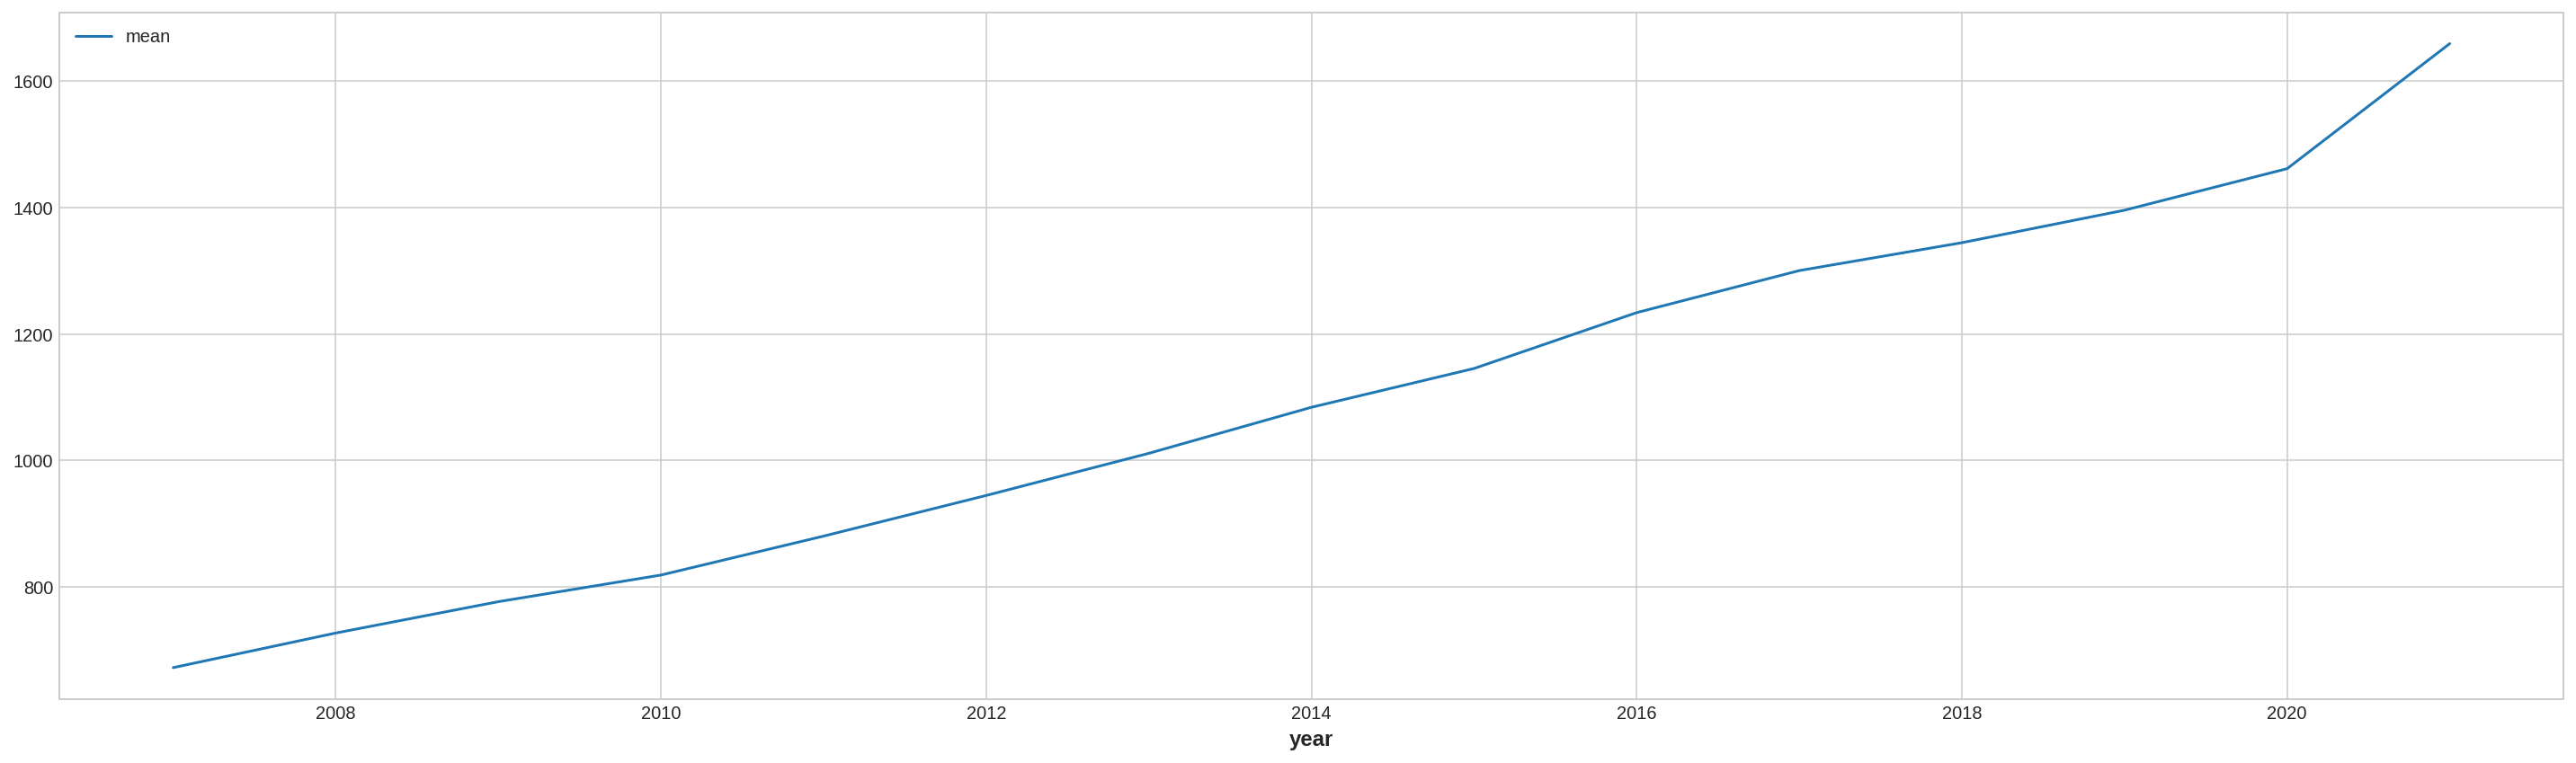

In [ ]:
#acompanhando a variável global_value (min e máx) em todos os estados ao longo do período
df.groupby(['year']).global_value.agg([np.mean]).plot(figsize = (20,6))



In [ ]:
#criando um df para o estado de São Paulo
df_sp = df[df['state'] == 'SP']
df_sp

,periodo,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
3306,2007-02,2007,2,SP,695.02,324.78,349.82,18.44,1.98,2.49
3307,2007-03,2007,3,SP,696.04,324.44,350.89,18.77,1.93,2.44
3308,2007-04,2007,4,SP,700.99,326.10,354.21,18.77,1.92,2.47
3309,2007-05,2007,5,SP,709.49,326.17,361.58,19.78,1.96,2.47
3310,2007-06,2007,6,SP,719.64,329.02,368.33,20.28,2.01,2.44
...,...,...,...,...,...,...,...,...,...,...
3475,2021-03,2021,3,SP,1599.58,651.86,899.31,45.30,3.11,6.59
3476,2021-04,2021,4,SP,1622.21,673.51,900.24,45.30,3.16,7.14
3477,2021-05,2021,5,SP,1658.43,687.41,921.50,46.33,3.19,7.33
3478,2021-06,2021,6,SP,1708.12,704.77,952.56,47.57,3.22,7.60


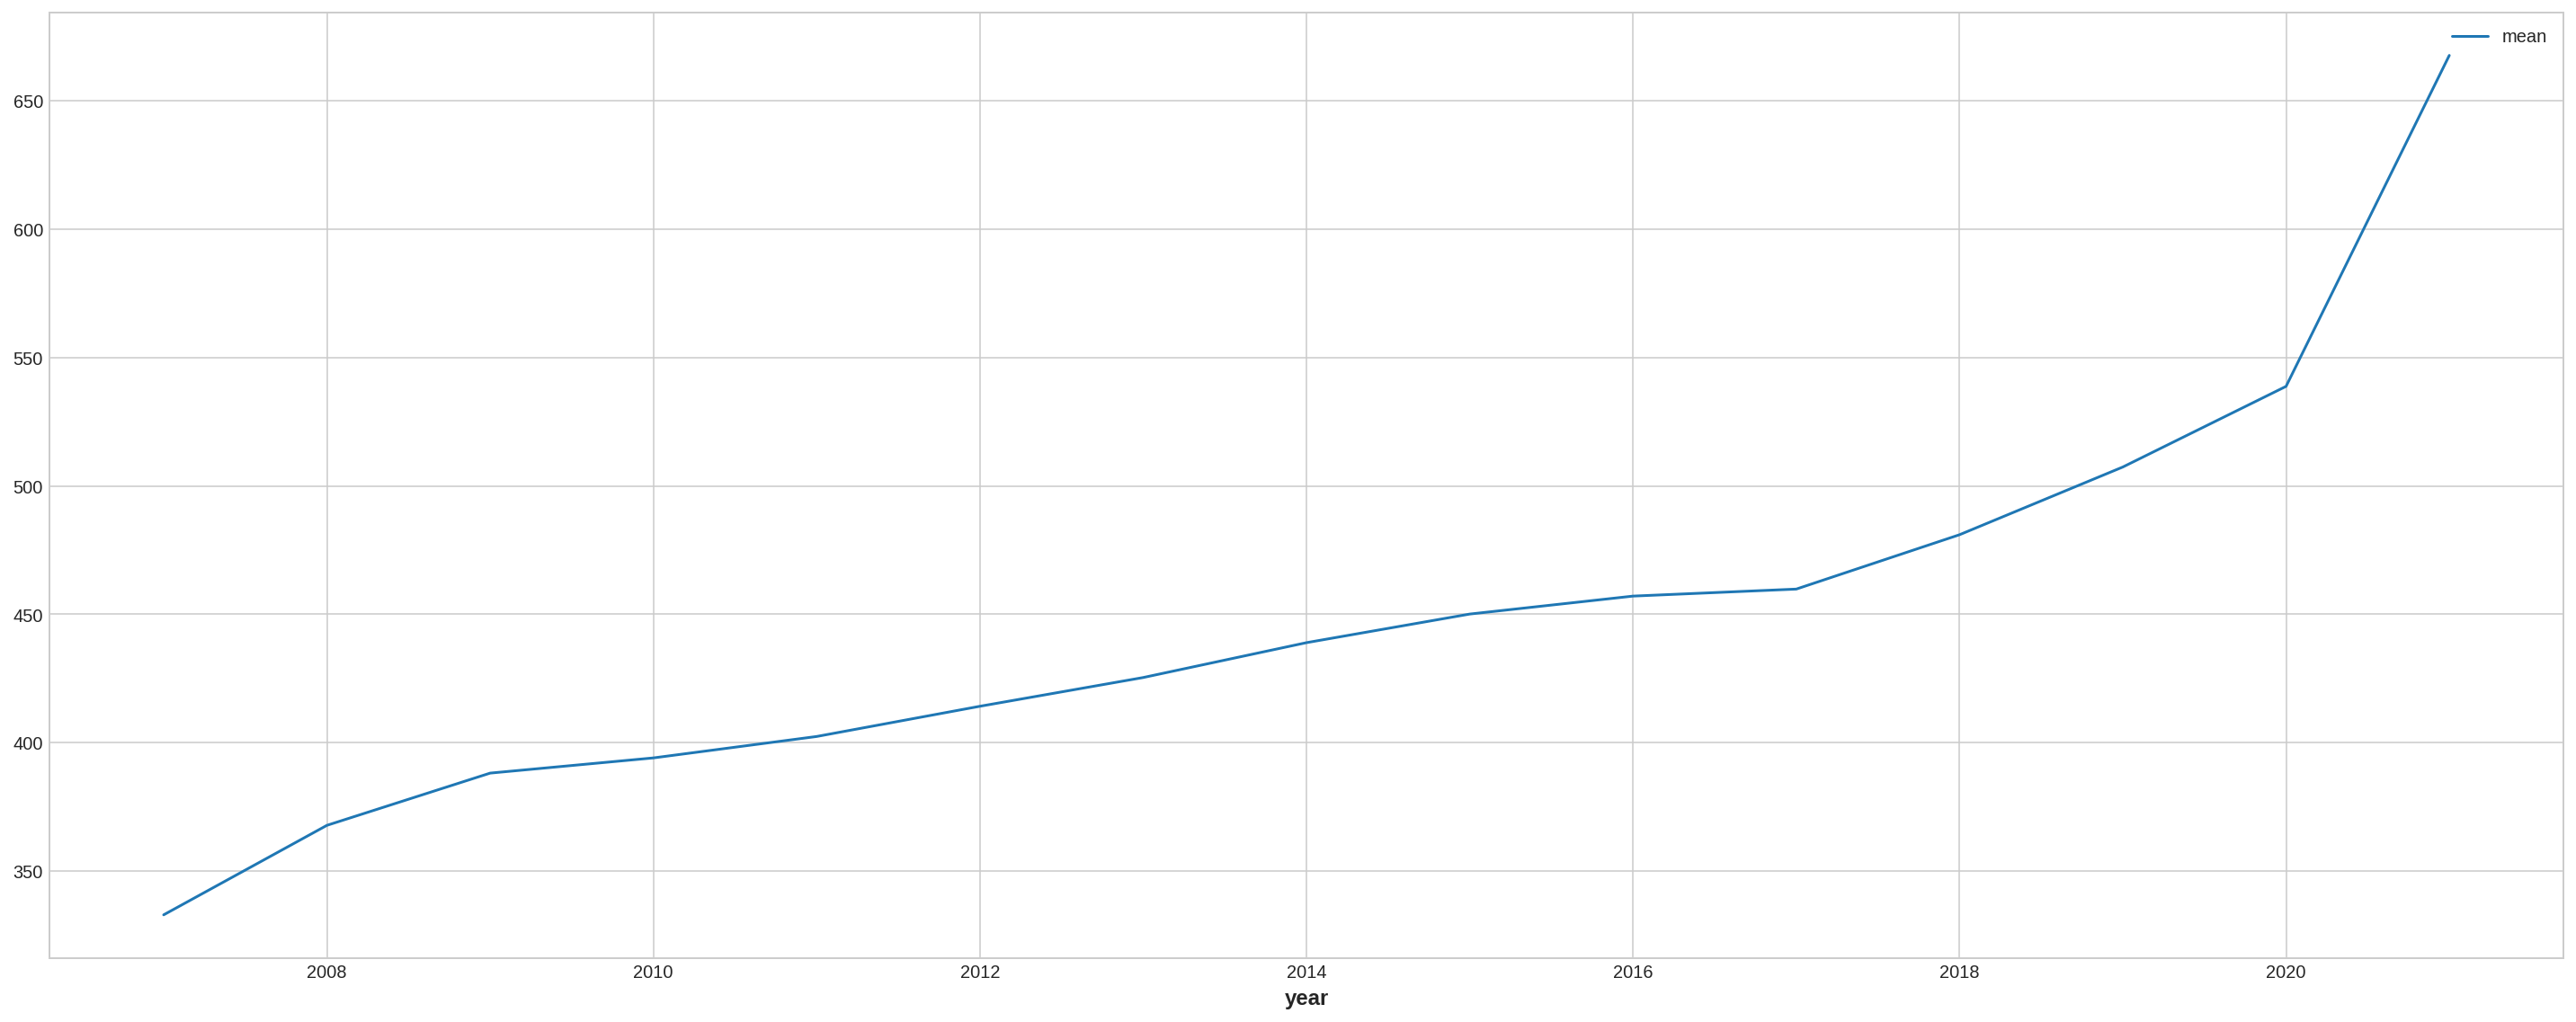

In [ ]:
#df_sp['year'].plot(figsize = (20,6))
df_sp.groupby(['year']).cm_value.agg([np.mean]).plot(figsize = (20,8))

In [ ]:
#criando um TS para global_values
df_sp_TS = pd.DataFrame(df_sp, columns = ['periodo','global_value'])
df_sp_TS


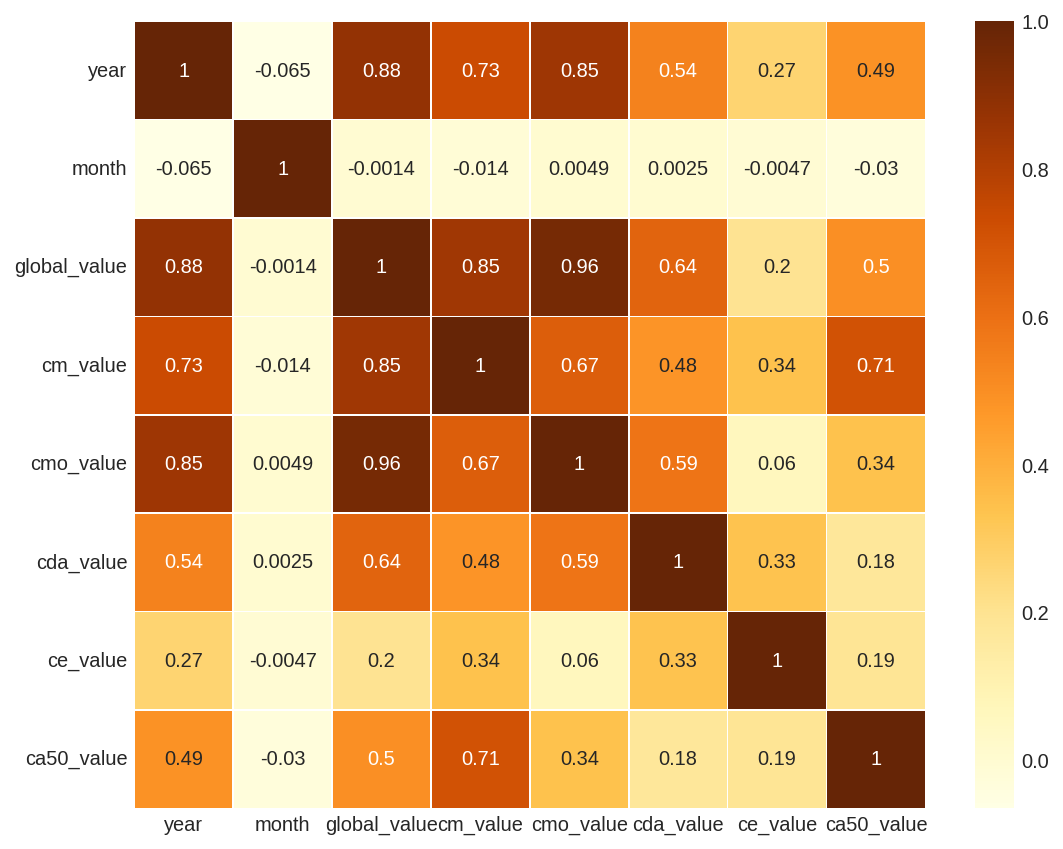

In [ ]:
#correlação ou covariância
corr_df = df.corr(method = 'pearson') #Utilizar método de pearson quano não houver presença de outliers
corr_df
#plotando com seaborn
plt.figure(figsize=(8, 6))


cmap = "YlOrBr"
sns.heatmap(corr_df, annot=True,  linewidths = .3, cmap = cmap)

plt.show()


#<font color='DarkBlue'>Perguntas de negócio

## 1.Quais são os 3 estados com o maior custo global atual? E quais são os com os menores valores?

In [ ]:
#filtrando os dados de 2021, verificando o último mês apontado
ano_2021 = df.loc[df.year == 2021]
ano_2021_mes7 = ano_2021.sort_values(by = ['global_value'], ascending = False).loc[ano_2021.month == 7]

In [ ]:
#visualizando o df
ano_2021_mes7

,periodo,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
3547,2021-07,2021,7,SC,2329.85,909.25,1366.99,49.84,3.78,7.120
3131,2021-07,2021,7,RS,2089.06,1144.99,858.51,70.61,14.95,11.240
1043,2021-07,2021,7,ES,2058.67,1026.25,944.82,84.24,3.37,7.050
1217,2021-07,2021,7,GO,2013.17,1007.47,945.70,51.90,8.10,6.560
2609,2021-07,2021,7,PR,1963.00,788.46,1100.55,69.39,4.60,8.680
2087,2021-07,2021,7,MT,1949.58,1027.03,805.84,96.72,19.99,12.530
2783,2021-07,2021,7,RJ,1885.60,833.77,991.80,55.13,4.90,8.890
347,2021-07,2021,7,AM,1801.65,948.97,772.95,68.42,11.31,9.990
1739,2021-07,2021,7,MG,1787.36,865.07,861.25,56.61,4.43,8.840
2435,2021-07,2021,7,PE,1781.33,926.12,772.54,78.48,4.19,9.990


Respectivamente; Santa Catarina, Rio Grande de Sul e Espírito Santo têm os três maiores valores de "global_value".
Quanto aos menores valores, por ordem crescente: Sergipe, Paraíba e Ceará

## 2. A tendência de aumento/queda nos preços manteve um padrão?

Esta secção tem o intuíto de apontar as nuances das taxas de aumento dos valores aplicados

# <font color = 'Red'>**Considerações e anotações.**

*   Eu **poderia** usar o arquivo direto no Power B.I, mas qual seria a **graça**?! O intuito desse notebook é treinar.
*   Data analisys não é Storytelling, mas eu quis pelo menos deixar este notebook claro para minha leitura posterior e para divulgação.
* Seria interessante apresentar visualizações de outras bibliotecas(ggplot,bokeh)
  * Gráficos interativos seriam bons para visualizações onde a densidade de pontos no gráfico é grande(ex:lag_plot)

* Pelo fato dos dados estarem distribuidos ao longo de um período (série temporal) todos os valores podem ter uma grande diferença (entre o primeiro período de aquisição e o último). Para este caso, deve-se tomar cuidado com análises estatísticas e possíveis falsos-positivos de outliers.

* Algo interessante seria avaliar "um bom estado para investir", relacionaria-se os custos com os  preço de venda dos imóveis

* Não faria sentido calcular um custo global médio nacional, dado a extensão territorial e margens nas diferenças dos custos

  * Seria interessante um comparativo em porcentagens dos valores entre os estados
      

 


> ***Quais perguntas de negócios quero responder:*** 
>1. Quais são os 3 estados com o maior custo global atual? E quais são os com os menores valores?
>2. A tendência de aumento/queda nos preços manteve um padrão?
>3. Prever os preços para 3 meses
>4. Qual relação podemos fazer com outras fontes de dados? (Ex: preço do aço,juros,PIB,inflação,etc)<font color='red'>**-opcional** 

###<font color='Gray'>**Outras notas** ### 

* 30/11- Seria interessante (para um estudo futuro), cruzar informações de fornecedores de 'aço ca50 10mm' para verificar se há alguma correlação com os preços praticados por estado (talvez geolocalização de fornecedores/mineradoras)


* 30/11- Relacionar este indicador com outros indicadores econômicos (juros,PIB,inflação,etc)

* 12/12- Esclarecer como o índice é calculado. (Ex: projeto de casa 'padrão')-> Talvez fique para o artigo/publicação

* 28/01- Introduzir/aperfeiçoar análise estatística (range, desvios, etc)

* 03/02 - Inserir visão geral de retorno de valor para o negócio. O que este estudo geraria de valor para o negócio? 

* 03/02 - Inserir/enfatizar pontos de melhoria no projeto

* 04/02 - Identificado falha na conversão de year e month para tipo "datetime"

* 12/02 -Por hora decide manter as colunas month e year (está mais prático a filtragem)

In [ ]:
#lembre que tem uma página no Notion para anotações para futura publicação
  #pontos de melhoria
  #pontos de dificuldade
  #pontos positivos
#plotar para visualizar/analisar os dados (Plot Serie Temporal,gráfico de linha)
  #plotar as diferentes colunas para comparar evolução dos diferentes preços
#lembrar explicar sobre como o custo é calculado: talvez isso fique para a
#publicação/artigo
#
#adicionar fontes de estudo/referências








### Referências

linha[14] https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

# Bucket

### Testes do tutorial do Kaggle

In [ ]:
#Testes do tutorial do Kaggle de Pandas
## Quais foram os últimos dados adquiridos/inseridos (ano)?
df.year.unique()#Qual último mês de dados adquiridos do ano de 2021?
ano_2021 = df.loc[df.year == 2021]
lista_mes_2021 = list(ano_2021.month.unique())
lista_mes_2021[-1:]
#Visualizando os últmos dados obtidos de todos os estados em 2021
mes_7_ano_2021 = ano_2021.loc[ano_2021.month == 7]
#//mes_7_ano_2021
# em caso de necessidade de ordenação ascendente pela coluna 'state':
ordenacao_mes = mes_7_ano_2021.sort_values(by =['state'])



In [ ]:
ano_2021

,periodo,year,month,state,global_value,cm_value,cmo_value,cda_value,ce_value,ca50_value
167,2021-01,2021,1,AL,1413.26,747.16,618.02,38.65,9.43,6.20
168,2021-02,2021,2,AL,1441.90,775.31,618.43,38.72,9.43,6.92
169,2021-03,2021,3,AL,1451.21,784.63,618.43,38.72,9.43,6.92
170,2021-04,2021,4,AL,1485.49,818.91,618.43,38.72,9.43,8.56
171,2021-05,2021,5,AL,1534.85,831.76,654.94,38.72,9.43,9.21
...,...,...,...,...,...,...,...,...,...,...
3543,2021-03,2021,3,SC,2171.33,819.38,1300.81,47.63,3.52,6.35
3544,2021-04,2021,4,SC,2203.29,848.55,1303.66,47.50,3.58,6.78
3545,2021-05,2021,5,SC,2253.79,879.74,1322.23,48.22,3.61,6.86
3546,2021-06,2021,6,SC,2307.92,896.13,1358.30,49.74,3.75,6.87


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()   #use .disable para desabilitar
#data_table.disable_dataframe_formatter()


In [ ]:
# #criando um DataFrame para cada estado
# # lista_estados = list(df.state.unique() )
# # len_lista_estados = len(lista_estados)


# # df_main = []
# # df_main
# # i = 0
# # for i in range(len_lista_estados):
# #   df_main[i] = df[df['state'] == lista_estados[i]]

# #tente isso -----------------------------------------------------------------------------------------------------------
# #create some data with Names column
# #data = pd.DataFrame({'Names': ['Joe', 'John', 'Jasper', 'Jez'] *4, 'Ob1' : np.random.rand(16), 'Ob2' : np.random.rand(16)})

# #create unique list of names
# UniqueState = df.state.unique()

# #create a data frame dictionary to store your data frames
# DataFrameDict = {elem : pd.DataFrame for elem in UniqueState}

# for key in DataFrameDict.keys():
#     DataFrameDict[key] = df[:][df.state == key]


In [ ]:
#criar um df para indicar os valores mínimos, máximos, etc...
#descriptor_counts = pd.Series([n_of_tropical, n_of_fruity], index=['tropical', 'fruity'])